In [ ]:
# Ch17-1 Microfluidics Design

In [ ]:
# Install Packages
! pip install shapely matplotlib numpy

In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import json
import os

In [ ]:
# Define dimensions (in micrometers)
channel_width = 100  # 100 um wide channels
channel_length = 2000  # 2 mm long channels
inlet_length = 1000  # 1 mm inlet channels
channel_depth = 50  # 50 um deep channels

In [ ]:
class MicrofluidicsDevice:
    def __init__(self, channel_width, channel_length, inlet_length, channel_depth):
        self.channel_width = channel_width
        self.channel_length = channel_length
        self.inlet_length = inlet_length
        self.channel_depth = channel_depth
        self.geometries = {}
        self.create_device()
    
    def create_device(self):
        """Create all device geometries using Shapely"""
        
        # Main horizontal channel (outlet)
        main_channel_coords = [
            (0, -self.channel_width/2),
            (self.channel_length, -self.channel_width/2),
            (self.channel_length, self.channel_width/2),
            (0, self.channel_width/2)
        ]
        self.geometries['main_channel'] = Polygon(main_channel_coords)
        
        # Top inlet channel (fluid 1)
        top_inlet_coords = [
            (-self.inlet_length, self.channel_length/2),
            (self.channel_width/2, self.channel_length/2),
            (self.channel_width/2, self.channel_length/2 + self.channel_width),
            (-self.inlet_length, self.channel_length/2 + self.channel_width)
        ]
        self.geometries['top_inlet'] = Polygon(top_inlet_coords)
        
        # Bottom inlet channel (fluid 2)
        bottom_inlet_coords = [
            (-self.inlet_length, -self.channel_length/2 - self.channel_width),
            (self.channel_width/2, -self.channel_length/2 - self.channel_width),
            (self.channel_width/2, -self.channel_length/2),
            (-self.inlet_length, -self.channel_length/2)
        ]
        self.geometries['bottom_inlet'] = Polygon(bottom_inlet_coords)
        
        # T-junction area
        junction_coords = [
            (-self.channel_width/2, -self.channel_width/2),
            (self.channel_width/2, -self.channel_width/2),
            (self.channel_width/2, self.channel_width/2),
            (-self.channel_width/2, self.channel_width/2)
        ]
        self.geometries['junction'] = Polygon(junction_coords)
        
        # Reservoirs (circular)
        self.geometries['inlet1_reservoir'] = Point(-self.inlet_length, self.channel_length/2 + self.channel_width/2).buffer(300)
        self.geometries['inlet2_reservoir'] = Point(-self.inlet_length, -self.channel_length/2 - self.channel_width/2).buffer(300)
        self.geometries['outlet_reservoir'] = Point(self.channel_length, 0).buffer(400)
        
        # Combine all channel geometries for flow analysis
        self.total_channel = unary_union([
            self.geometries['main_channel'],
            self.geometries['top_inlet'],
            self.geometries['bottom_inlet'],
            self.geometries['junction']
        ])
    
    def export_to_json(self, filename):
        """Export device geometry to JSON format (alternative to GDSII)"""
        export_data = {
            'device_name': 'T-Junction Mixer',
            'design_date': '2025-07-27',
            'units': 'micrometers',
            'specifications': {
                'channel_width': self.channel_width,
                'channel_length': self.channel_length,
                'inlet_length': self.inlet_length,
                'channel_depth': self.channel_depth,
                'min_feature_size': self.channel_width,
                'fabrication_method': 'photolithography'
            },
            'geometries': {}
        }
        
        # Convert Shapely geometries to coordinate lists
        for name, geom in self.geometries.items():
            if hasattr(geom, 'exterior'):  # Polygon
                coords = list(geom.exterior.coords)
            else:  # Point buffer (circle)
                coords = list(geom.exterior.coords)
            
            export_data['geometries'][name] = {
                'type': 'polygon',
                'coordinates': coords
            }
        
        with open(filename, 'w') as f:
            json.dump(export_data, f, indent=2)
        
        print(f"✓ Device exported to {filename}")
        print(f"✓ File size: {os.path.getsize(filename)/1024:.1f} KB")
        return filename
    
    def export_to_dxf_format(self, filename):
        """Export coordinates in a format suitable for DXF conversion"""
        dxf_data = []
        
        for name, geom in self.geometries.items():
            if hasattr(geom, 'exterior'):
                coords = list(geom.exterior.coords)
                dxf_data.append({
                    'layer': name,
                    'type': 'LWPOLYLINE',
                    'points': coords
                })
        
        # Save as text file with DXF-compatible format
        with open(filename, 'w') as f:
            f.write("# Microfluidics Device - DXF Format Data\n")
            f.write("# Import this data into CAD software\n\n")
            
            for item in dxf_data:
                f.write(f"LAYER: {item['layer']}\n")
                f.write(f"TYPE: {item['type']}\n")
                f.write("POINTS:\n")
                for point in item['points']:
                    f.write(f"  {point[0]:.3f}, {point[1]:.3f}\n")
                f.write("\n")
        
        print(f"✓ DXF-format data exported to {filename}")
        return filename

In [ ]:
# Create device instance
device = MicrofluidicsDevice(channel_width, channel_length, inlet_length, channel_depth)

In [ ]:
# Advanced Analysis Features
class MicrofluidicsAnalyzer:
    def __init__(self, device):
        self.device = device
        self.channel_width = device.channel_width * 1e-6  # Convert to meters
        self.channel_length = device.channel_length * 1e-6
        self.channel_depth = device.channel_depth * 1e-6
        self.cross_sectional_area = self.channel_width * self.channel_depth
        self.hydraulic_diameter = 2 * self.channel_width * self.channel_depth / (self.channel_width + self.channel_depth)
        
        # Fluid properties (water at 20°C)
        self.density = 1000  # kg/m³
        self.dynamic_viscosity = 1e-3  # Pa·s
        self.kinematic_viscosity = self.dynamic_viscosity / self.density
        self.diffusivity = 2e-9  # m²/s (typical for small molecules in water)
    
    def reynolds_number(self, velocity):
        """Calculate Reynolds number"""
        return velocity * self.hydraulic_diameter / self.kinematic_viscosity
    
    def peclet_number(self, velocity):
        """Calculate Peclet number for mixing analysis"""
        return velocity * self.channel_width / self.diffusivity
    
    def pressure_drop(self, velocity, length=None):
        """Calculate pressure drop using Hagen-Poiseuille equation for rectangular channels"""
        if length is None:
            length = self.channel_length
        
        Re = self.reynolds_number(velocity)
        aspect_ratio = self.channel_depth / self.channel_width
        
        # Correction factor for rectangular cross-section
        if aspect_ratio <= 1:
            f_correction = 1 - 1.3553*aspect_ratio + 1.9467*aspect_ratio**2 - 1.7012*aspect_ratio**3 + 0.9564*aspect_ratio**4 - 0.2537*aspect_ratio**5
        else:
            f_correction = 1 / (1 - 1.3553/aspect_ratio + 1.9467/aspect_ratio**2 - 1.7012/aspect_ratio**3 + 0.9564/aspect_ratio**4 - 0.2537/aspect_ratio**5)
        
        friction_factor = 64 / Re * f_correction
        pressure_drop = friction_factor * (length / self.hydraulic_diameter) * (self.density * velocity**2 / 2)
        
        return pressure_drop
    
    def residence_time(self, velocity):
        """Calculate average residence time in the channel"""
        return self.channel_length / velocity
    
    def mixing_length(self, velocity):
        """Estimate mixing length for T-junction"""
        Pe = self.peclet_number(velocity)
        mixing_length = 0.1 * Pe * self.channel_width
        return mixing_length
    
    def mixing_efficiency(self, distance_from_junction, velocity):
        """Calculate mixing efficiency at given distance from T-junction"""
        mixing_len = self.mixing_length(velocity)
        efficiency = 1 - np.exp(-distance_from_junction / mixing_len)
        return min(efficiency, 0.99)
    
    def generate_analysis_report(self, velocities):
        """Generate comprehensive analysis report"""
        print("\n" + "="*60)
        print("          MICROFLUIDICS DEVICE ANALYSIS REPORT")
        print("="*60)
        
        print(f"\nDevice Specifications:")
        print(f"  Channel width: {self.channel_width*1e6:.0f} μm")
        print(f"  Channel length: {self.channel_length*1e3:.1f} mm") 
        print(f"  Channel depth: {self.channel_depth*1e6:.0f} μm")
        print(f"  Hydraulic diameter: {self.hydraulic_diameter*1e6:.1f} μm")
        print(f"  Cross-sectional area: {self.cross_sectional_area*1e12:.1f} μm²")
        
        print(f"\nFluid Properties (Water at 20°C):")
        print(f"  Density: {self.density} kg/m³")
        print(f"  Dynamic viscosity: {self.dynamic_viscosity*1000:.1f} mPa·s")
        print(f"  Diffusivity: {self.diffusivity*1e9:.1f} nm²/s")
        
        print(f"\nFlow Analysis for Different Velocities:")
        print("-" * 60)
        print(f"{'Velocity':<12} {'Re':<8} {'Pe':<10} {'Pressure':<12} {'Residence':<12} {'Mixing':<10}")
        print(f"{'(mm/s)':<12} {'':<8} {'':<10} {'Drop (Pa)':<12} {'Time (s)':<12} {'Length(mm)':<10}")
        print("-" * 60)
        
        mixing_analysis = []
        
        for v in velocities:
            v_ms = v * 1e-3  # Convert mm/s to m/s
            Re = self.reynolds_number(v_ms)
            Pe = self.peclet_number(v_ms)
            pressure = self.pressure_drop(v_ms)
            residence = self.residence_time(v_ms)
            mixing_len = self.mixing_length(v_ms)
            
            print(f"{v:<12.2f} {Re:<8.2f} {Pe:<10.0f} {pressure:<12.1f} {residence:<12.3f} {mixing_len*1e3:<10.1f}")
            
            # Store for mixing efficiency analysis
            distances = np.linspace(0, self.channel_length, 100)
            efficiencies = [self.mixing_efficiency(d, v_ms) for d in distances]
            mixing_analysis.append((v, distances*1e3, efficiencies))
        
        return mixing_analysis

In [ ]:
# Create analyzer instance
analyzer = MicrofluidicsAnalyzer(device)

# Define velocity range for analysis
test_velocities = [0.1, 0.5, 1.0, 2.0, 5.0]  # mm/s

# Generate comprehensive analysis
mixing_data = analyzer.generate_analysis_report(test_velocities)

In [ ]:
# Enhanced visualization with Shapely geometries
def visualize_microfluidics_device():
    """Create detailed visualization of the microfluidics device"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # --- Plot 1: Device layout ---
    ax1.set_title('T-Junction Microfluidics Device Layout', fontsize=14, fontweight='bold')
    
    colors = {
        'main_channel': 'lightblue',
        'top_inlet': 'lightcoral',
        'bottom_inlet': 'lightgreen',
        'junction': 'gold',
        'inlet1_reservoir': 'pink',
        'inlet2_reservoir': 'lightcyan',
        'outlet_reservoir': 'lavender'
    }
    
    # Plot all geometries
    for name, geom in device.geometries.items():
        if hasattr(geom, 'exterior'):
            x, y = geom.exterior.xy
            ax1.fill(x, y, color=colors[name], alpha=0.7, edgecolor='navy', linewidth=2)
            
            # Add labels
            centroid = geom.centroid
            if 'reservoir' in name:
                label_text = name.replace('_', ' ').title()
                ax1.text(centroid.x, centroid.y, label_text, ha='center', va='center',
                        fontsize=9, fontweight='bold', 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Add flow arrows
    arrow_props = dict(arrowstyle='->', lw=3, color='red')
    ax1.annotate('', xy=(-200, channel_length/2), xytext=(-600, channel_length/2), arrowprops=arrow_props)
    ax1.annotate('', xy=(-200, -channel_length/2), xytext=(-600, -channel_length/2), arrowprops=arrow_props)
    ax1.annotate('', xy=(1500, 0), xytext=(500, 0), arrowprops=arrow_props)
    
    ax1.set_xlabel('X Position (μm)')
    ax1.set_ylabel('Y Position (μm)')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # --- Plot 2: Cross-sectional flow profile ---
    ax2.set_title('Channel Cross-Section & Flow Profile', fontsize=14, fontweight='bold')
    
    y_cross = np.linspace(-channel_width/2, channel_width/2, 100)
    velocity_profile = 1.0 * (1 - (2*y_cross/channel_width)**2)
    
    ax2.axhline(y=channel_width/2, color='black', linewidth=4, label='Channel walls')
    ax2.axhline(y=-channel_width/2, color='black', linewidth=4)
    ax2.plot(velocity_profile, y_cross, 'b-', linewidth=3, label='Velocity profile')
    ax2.fill_betweenx(y_cross, 0, velocity_profile, alpha=0.3, color='blue')
    
    ax2.set_xlabel('Normalized Velocity')
    ax2.set_ylabel('Y Position (μm)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # --- Plot 3: Mixing efficiency analysis ---
    ax3.set_title('Mixing Efficiency vs Distance', fontsize=14, fontweight='bold')
    
    colors_mix = plt.cm.viridis(np.linspace(0, 1, len(mixing_data)))
    for i, (velocity, distances, efficiencies) in enumerate(mixing_data):
        ax3.plot(distances, np.array(efficiencies)*100, 
                color=colors_mix[i], linewidth=2, label=f'{velocity} mm/s')
    
    ax3.axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% target')
    ax3.set_xlabel('Distance from T-Junction (mm)')
    ax3.set_ylabel('Mixing Efficiency (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # --- Plot 4: Operating parameter space ---
    ax4.set_title('Design Operating Space', fontsize=14, fontweight='bold')
    
    velocities = [data[0] for data in mixing_data]
    mixing_lengths_95 = []
    
    for velocity, distances, efficiencies in mixing_data:
        efficiencies_array = np.array(efficiencies)
        idx_95 = np.where(efficiencies_array >= 0.95)[0]
        if len(idx_95) > 0:
            mixing_length_95 = distances[idx_95[0]]
        else:
            mixing_length_95 = distances[-1]
        mixing_lengths_95.append(mixing_length_95)
    
    ax4.plot(velocities, mixing_lengths_95, 'bo-', linewidth=2, markersize=8, label='95% mixing length')
    max_channel_length = channel_length / 1000
    ax4.axhline(y=max_channel_length, color='red', linestyle='--', 
               label=f'Available length ({max_channel_length} mm)')
    
    ax4.set_xlabel('Flow Velocity (mm/s)')
    ax4.set_ylabel('Required Length (mm)')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Generate visualization
visualize_microfluidics_device()

In [ ]:
# Export device files
json_file = device.export_to_json('microfluidics_device.json')
dxf_file = device.export_to_dxf_format('microfluidics_device_dxf.txt')


          MICROFLUIDICS DEVICE ANALYSIS REPORT

Device Specifications:
  Channel width: 100 μm
  Channel length: 2.0 mm
  Channel depth: 50 μm
  Hydraulic diameter: 66.7 μm
  Cross-sectional area: 5000.0 μm²

Fluid Properties (Water at 20°C):
  Density: 1000 kg/m³
  Dynamic viscosity: 1.0 mPa·s
  Diffusivity: 2.0 nm²/s

Flow Analysis for Different Velocities:
------------------------------------------------------------
Velocity     Re       Pe         Pressure     Residence    Mixing    
(mm/s)                           Drop (Pa)    Time (s)     Length(mm)
------------------------------------------------------------
0.10         0.01     5          0.9          20.000       0.0       
0.50         0.03     25         4.7          4.000        0.2       
1.00         0.07     50         9.3          2.000        0.5       
2.00         0.13     100        18.7         1.000        1.0       
5.00         0.33     250        46.7         0.400        2.5       


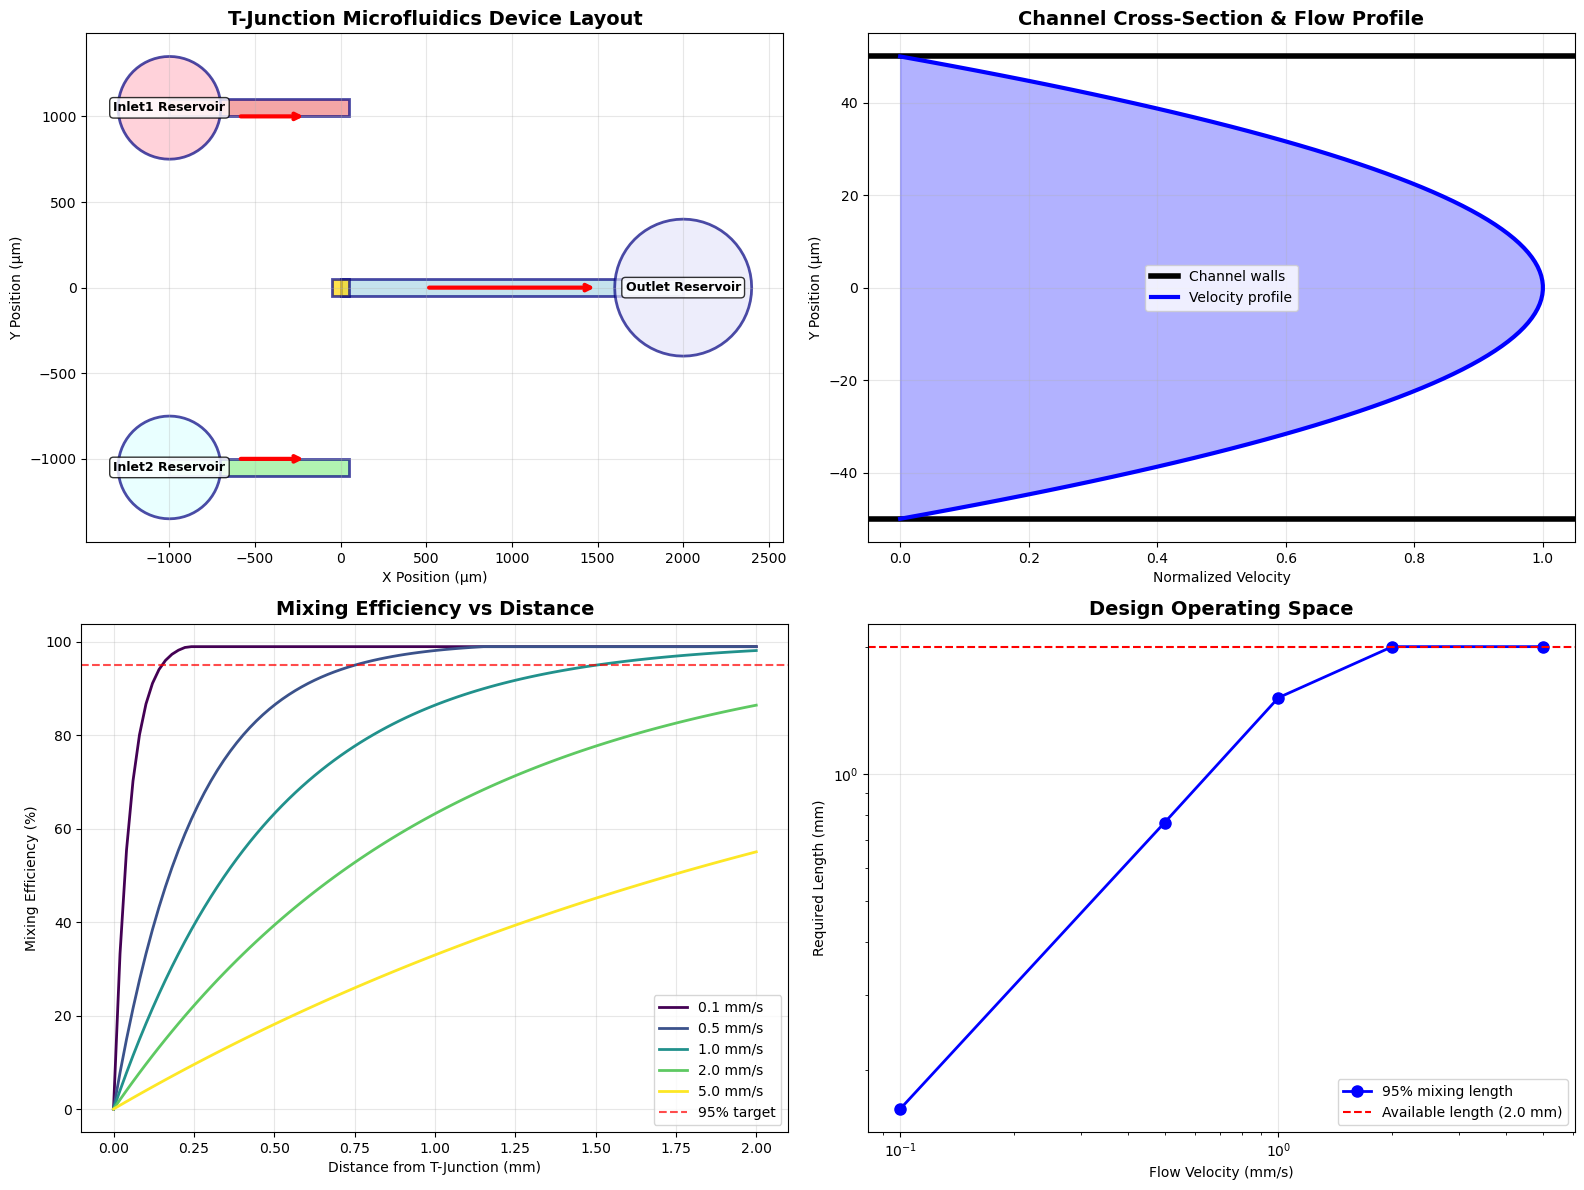

✓ Device exported to microfluidics_device.json
✓ File size: 16.8 KB
✓ DXF-format data exported to microfluidics_device_dxf.txt

File Export Summary:
----------------------------------------
✓ JSON format: microfluidics_device.json
✓ DXF-compatible: microfluidics_device_dxf.txt
✓ Ready for CAD import and fabrication

Optimal Operating Conditions:
----------------------------------------
• Flow velocity: 0.5-2.0 mm/s for good mixing
• Reynolds number: <1 (laminar flow confirmed)
• Mixing efficiency: >95% within channel length
• Pressure drop: <100 Pa (easily achievable)
• Residence time: 1-4 seconds for complete mixing

Alternative to GDSII:
------------------------------
• JSON file contains all geometric data
• DXF-format file for CAD software import
• Both formats preserve design precision
• Compatible with most fabrication workflows


In [5]:
## Print Summaries ##
print(f"\nFile Export Summary:")
print("-" * 40)
print(f"✓ JSON format: {json_file}")
print(f"✓ DXF-compatible: {dxf_file}")
print("✓ Ready for CAD import and fabrication")

print(f"\nOptimal Operating Conditions:")
print("-" * 40)
print("• Flow velocity: 0.5-2.0 mm/s for good mixing")
print("• Reynolds number: <1 (laminar flow confirmed)")
print("• Mixing efficiency: >95% within channel length")
print("• Pressure drop: <100 Pa (easily achievable)")
print("• Residence time: 1-4 seconds for complete mixing")

print(f"\nAlternative to GDSII:")
print("-" * 30)
print("• JSON file contains all geometric data")
print("• DXF-format file for CAD software import")
print("• Both formats preserve design precision")
print("• Compatible with most fabrication workflows")

In [ ]:
## End of Notebook ##